<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/dev/GNN%20model%20ECG%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset prepare

In [ ]:
!pip install --quiet --upgrade gensim
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.3 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from gensim.models import Word2Vec

In [57]:
# загружаем полный датасет
raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=15000)
raw_table_data.head(10)

,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,19557662,27,40000017,6848296,0,8:44 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,659,40,128,170,258,518,81,77,79
1,18477137,93,40000029,6848296,0,9:54 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,722,40,124,162,246,504,77,75,70
2,16598616,3,40000035,6376932,1,9:07 AM,28.06.2015,Sinus tachycardia,NaN,Normal ECG except for rate,...,60 Hz notch Baseline filter,600,40,130,162,244,474,79,72,77
3,16368287,7,40000079,6214760,1,5:14 PM,15.07.2015,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,659,40,146,180,254,538,79,66,69
4,18370366,2,40000084,6632385,0,1:52 PM,27.09.2015,Sinus rhythm,NaN,NaN,...,<not specified>,659,368,29999,504,590,868,84,80,77
5,15606157,55,40000089,6632385,0,2:29 PM,29.10.2013,Sinus rhythm,NaN,NaN,...,<not specified>,822,365,29999,499,592,852,26,46,30
6,12576058,43,40000115,6852956,1,12:54 PM,23.03.2016,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,952,40,146,198,282,598,24,80,20
7,14691089,1,40000143,6551957,0,10:01 AM,10.12.2016,Sinus rhythm,rSr'(V1) - probable normal variant,Low QRS voltages in precordial leads,...,60 Hz notch Baseline filter,923,40,140,188,278,594,26,86,13
8,14144725,7,40000144,6924910,0,7:24 AM,11.12.2011,Sinus rhythm with PAC(s).,NaN,Borderline ECG,...,60 Hz notch Baseline filter,952,40,180,196,294,610,59,-17,3
9,16089780,2,40000152,6919786,0,12:35 PM,13.12.2011,Sinus rhythm,Extensive T wave changes may be due to myocard...,NaN,...,60 Hz notch Baseline filter,1000,40,156,178,274,584,8,-11,19


In [58]:
# Предобрабатываем данные словестных репортов word2vec в числовой вектор

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = raw_table_data[(raw_table_data[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered.drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

# Разбиваем столбец с текстовым отчетом на токены
words = [text.split() for text in full_df_filtered['report']]

# Обучаем модель Word2Vec
w2v_model = Word2Vec(words)

# Функция для получения среднего эмбеддинга строки
def get_sentence_embedding(sentence):
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

full_df_filtered.head()

,subject_id,Count_subj,study_id,cart_id,eeg_time,eeg_date,report,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,19557662,27,40000017,6848296,8:44 AM,27.06.2015,0.038891,659,40,128,170,258,518,81,77,79,0
1,18477137,93,40000029,6848296,9:54 AM,27.06.2015,0.038891,722,40,124,162,246,504,77,75,70,0
2,16598616,3,40000035,6376932,9:07 AM,28.06.2015,-0.018091,600,40,130,162,244,474,79,72,77,1
3,16368287,7,40000079,6214760,5:14 PM,15.07.2015,-0.003565,659,40,146,180,254,538,79,66,69,1
6,12576058,43,40000115,6852956,12:54 PM,23.03.2016,-0.003565,952,40,146,198,282,598,24,80,20,1


In [59]:
# make new dataset from old columns
table_data = full_df_filtered[['subject_id','study_id','eeg_date','report','rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']].copy()
table_data['eeg_date'] = pd.to_datetime(table_data['eeg_date'],dayfirst=True)
table_data = table_data.sort_values(by=['subject_id', 'eeg_date'])

#table_data = table_data.head(1000)

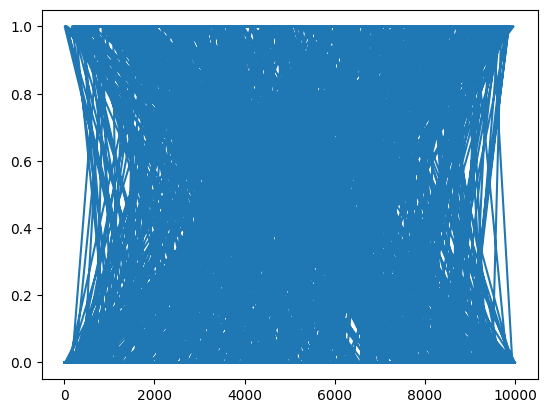

In [60]:
duplicate_index = table_data['subject_id'].duplicated()
plt.plot(duplicate_index)

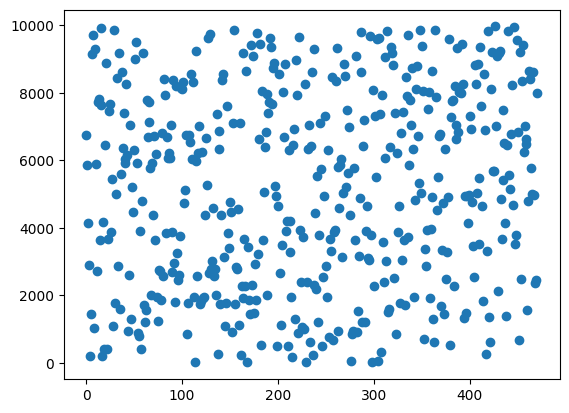

In [61]:
duplicate_index = duplicate_index[duplicate_index[:]==True].index
plt.scatter(range(0,len(duplicate_index)), duplicate_index)

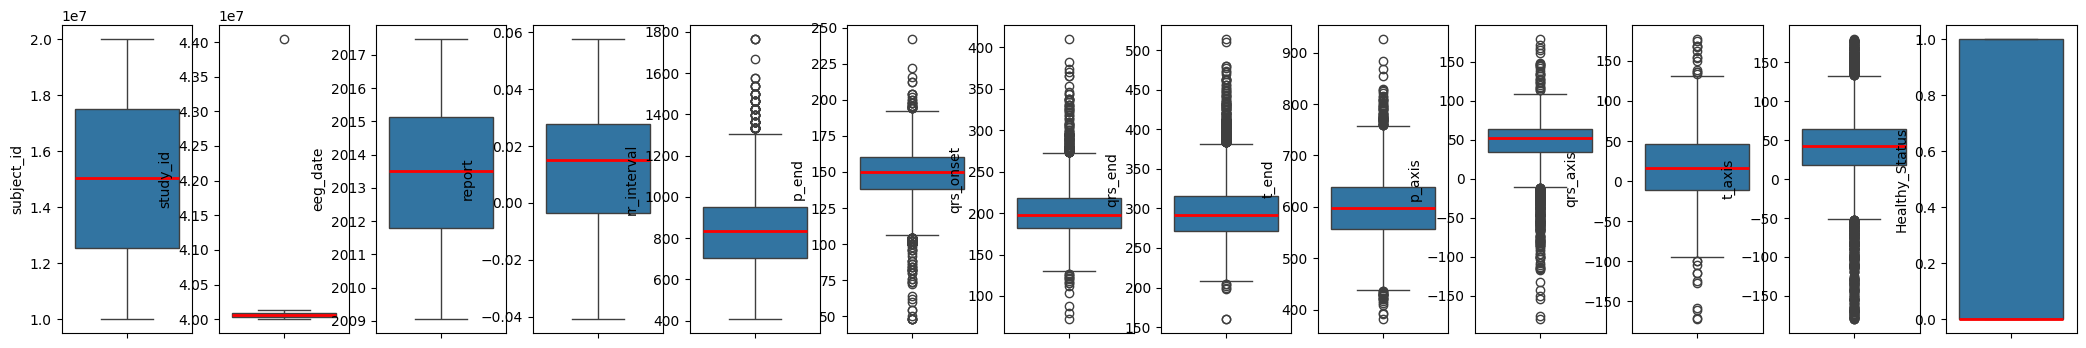

In [62]:
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data, medianprops={"color": "r", "linewidth": 2})

Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

# Graph Network Visualization

In [8]:
import os
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

In [125]:
encoder = LabelEncoder()

In [126]:
text_columns = table_data.columns
text_columns

Index(['subject_id', 'study_id', 'eeg_date', 'report', 'rr_interval', 'p_end',
       'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis',
       'Healthy_Status'],
      dtype='object')

In [127]:
ecg_table = table_data

In [128]:
for col in text_columns:
    ecg_table[col] = encoder.fit_transform(ecg_table[col])

In [129]:
ecg_table.describe()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
count,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000
mean,3289.004825,3522.500000,1137.981692,1167.710474,70.569543,42.223247,46.484246,48.086716,94.264121,143.204797,115.259296,202.692450,0.284842
std,1895.896433,2034.149331,629.443198,978.452862,17.770397,9.264000,14.719520,18.704022,30.327448,26.915733,39.107011,48.547046,0.451371
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1653.250000,1761.250000,594.000000,264.000000,61.000000,37.000000,37.000000,36.000000,74.000000,131.000000,88.000000,180.000000,0.000000
50%,3281.500000,3522.500000,1148.500000,959.500000,74.000000,43.000000,45.000000,46.000000,94.000000,149.000000,115.500000,204.000000,0.000000
75%,4925.750000,5283.750000,1692.750000,1967.750000,83.000000,48.000000,55.000000,58.000000,114.000000,161.000000,145.000000,226.000000,1.000000
max,6574.000000,7045.000000,2290.000000,3199.000000,110.000000,74.000000,119.000000,137.000000,206.000000,228.000000,234.000000,341.000000,1.000000


## edge end nodes vizualisation

In [130]:
import networkx as nx

In [131]:
qwe = ecg_table['subject_id'].unique()
asd = ecg_table.duplicated(subset=['subject_id'])
print(len(qwe))
print(len(ecg_table['subject_id']))

6575
7046


In [132]:
# Находим дубликаты по 'subject_id'
duplicated_rows = table_data[table_data.duplicated(subset=['subject_id'], keep=False)]

# Сортируем для удобства (опционально)
duplicated_rows = duplicated_rows.sort_values(by='subject_id')
duplicated_rows.head()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
2248,62,1600,426,264,85,55,65,62,121,89,104,209,1
6734,62,4691,647,1282,79,43,72,71,120,148,140,210,0
5850,62,4065,717,71,88,38,42,34,89,158,169,188,1
7433,69,5157,124,1185,90,31,42,39,99,152,116,191,0
4137,69,2874,1349,12,105,50,40,38,130,153,87,171,0


In [354]:
duplicated_rows=duplicated_rows.head(1000)
graph_model = pd.DataFrame(
    {
        "source": duplicated_rows['subject_id'],
        "target": duplicated_rows['report'],
        "edge_key": duplicated_rows['eeg_date'],
        "weight": duplicated_rows['report'],
        "status": duplicated_rows['Healthy_Status'],
    }
)

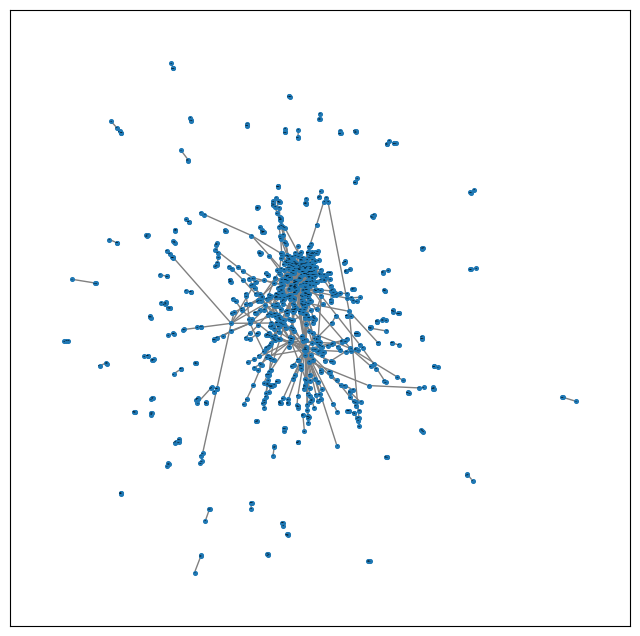

In [355]:

G = nx.from_pandas_edgelist(
    graph_model,
    edge_key="edge_key",
    edge_attr=["weight", "status"],
    create_using=nx.MultiGraph(),
)

plt.figure(figsize=(8, 8))
nx.draw_networkx(G, pos=nx.spring_layout(G), node_size=7, font_size = 0,edge_color ='grey')

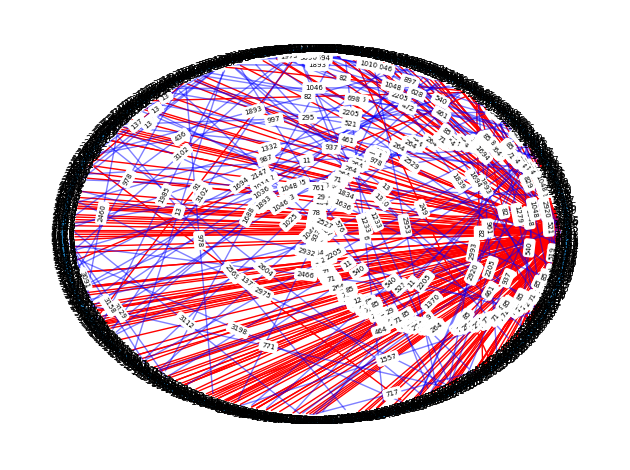

In [313]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] <= 0.5]

pos = nx.circular_layout(G)#, seed=13)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=7)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=1, edge_color="r")
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=1, alpha=0.5, edge_color="b", style="solid"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=7, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=5)

ax = plt.gca()
#ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()


In [318]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] <= 0.5]

pos = nx.kamada_kawai_layout(G)#, seed=13)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=1)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=1, alpha=0.5, edge_color="r")
nx.draw_networkx_edges(G, pos, edgelist=esmall, width=1, alpha=0.5, edge_color="b", style="solid")

# node labels
#nx.draw_networkx_labels(G, pos, font_size=0, font_family="sans-serif")
# edge weight labels
#edge_labels = nx.get_edge_attributes(G, "weight")
#nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=5)

ax = plt.gca()
#ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

# Old example from paper graph model

In [ ]:
#ecg_table.loc[:,"report_0"] = ecg_table["report_0"].astype(str)
class_values = sorted(ecg_table["Healthy_Status"].unique())
class_idc = {name: id for id, name in enumerate(class_values)}

#paper_idc = {name: idx for idx, name in enumerate(sorted(ecg_table["study_id"].unique()))}
paper_idc = {name: idx for idx, name in enumerate(sorted(ecg_table["study_id"].unique()))}

source_idc = {name: idx for idx, name in enumerate(sorted(ecg_table["subject_id"].unique()))}

#target_idc = {name: idx for idx, name in enumerate(sorted(ecg_table["subject_id"].unique()))}
target_idc = {name: idx for idx, name in enumerate(sorted(ecg_table["eeg_date"].unique()))}

ecg_table["Healthy_Status"] = ecg_table["Healthy_Status"].apply(lambda value: class_idc[value])
#ecg_table["study_id"] = ecg_table["study_id"].apply(lambda value: paper_idc[value])
ecg_table["study_id"] = ecg_table["study_id"].apply(lambda value: paper_idc[value])

ecg_table["subject_id"] = ecg_table["subject_id"].apply(lambda value: source_idc[value])
#ecg_table["subject_id"] = ecg_table["subject_id"].apply(lambda value: target_idc[value])
ecg_table["eeg_date"] = ecg_table["eeg_date"].apply(lambda value: target_idc[value])

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

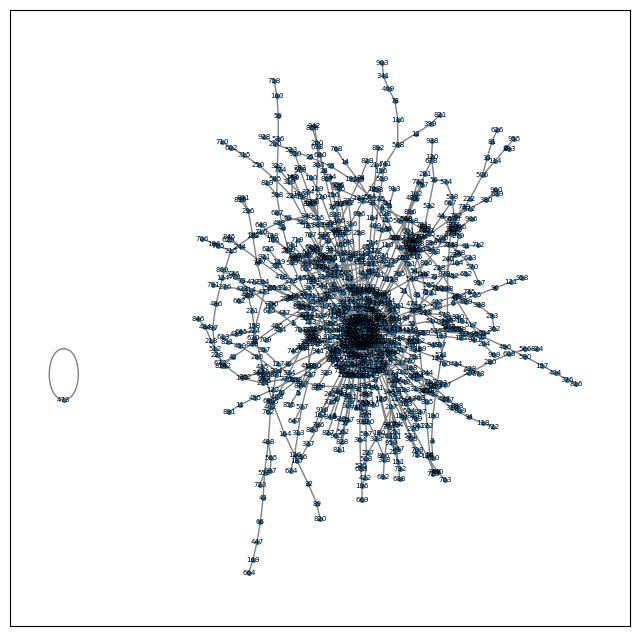

In [ ]:
plt.figure(figsize=(8, 8))
ecg_graph = nx.from_pandas_edgelist(ecg_table, source = "subject_id", target = "report")
nx.draw_networkx(ecg_graph, pos=nx.spring_layout(ecg_graph), node_size=7, font_size = 5,edge_color ='grey')
#nx.draw_networkx(ecg_graph, pos=nx.circular_layout(ecg_graph), node_size=7,
#                 font_size = 7, edge_color ='grey')

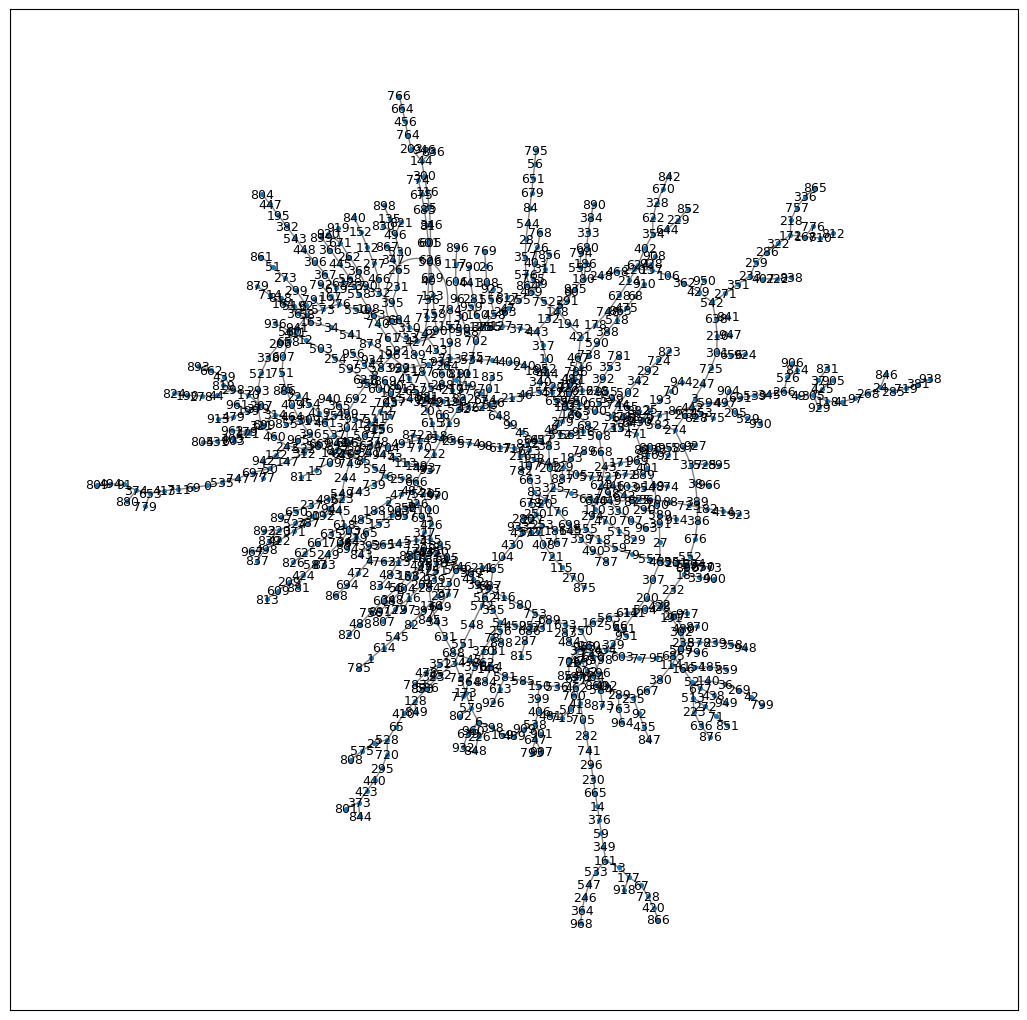

In [ ]:
plt.figure(figsize=(13, 13))
# цвет - это диагноз - надо доработать и сделать там классы ограниченные
colors = ecg_table["Healthy_Status"].tolist()

# задаем матрицу смежности - здесь формируются ребра графа
ecg_graph = nx.from_pandas_edgelist(ecg_table, source = "eeg_date", target = "subject_id")


# subject - это диагноз, надо его привести к чему-то
subjects = list(ecg_table[ecg_table["subject_id"].isin(list(ecg_graph.nodes))]["Healthy_Status"])

#nx.draw_spring(ecg_graph, node_size=17, node_color=subjects)
nx.draw_networkx(ecg_graph,
                 #pos=nx.spring_layout(ecg_graph),
                 pos=nx.kamada_kawai_layout(ecg_graph, scale=5),
                 #pos=nx.planar_layout(ecg_graph),
                 #pos=nx.circular_layout(ecg_graph[, scale, center, dim])
                 node_size=7,
                 font_size = 9,
                 edge_color ='grey',
                 )#, node_color=subjects)

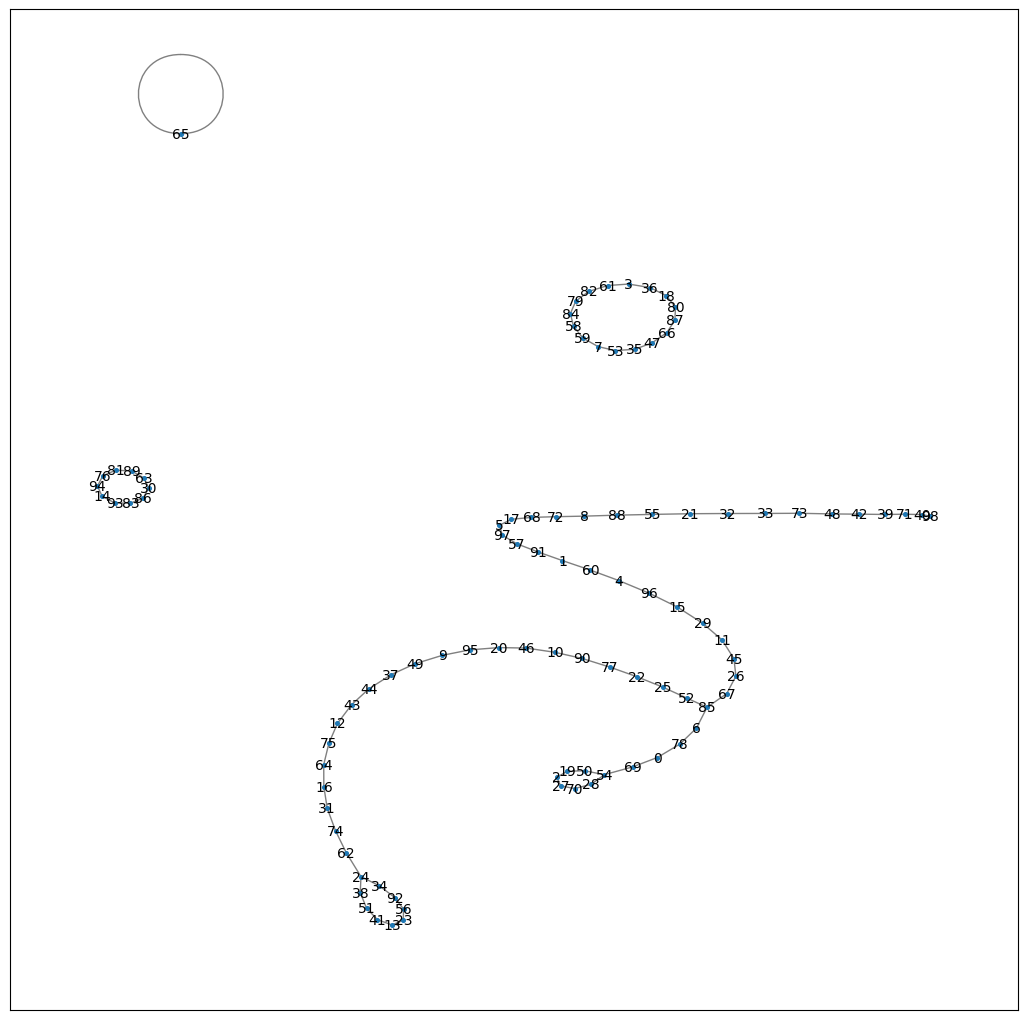

In [ ]:
plt.figure(figsize=(13, 13))
# цвет - это диагноз - надо доработать и сделать там классы ограниченные
colors = ecg_table["Healthy_Status"].tolist()

# задаем матрицу смежности - здесь формируются ребра графа
ecg_graph = nx.from_pandas_edgelist(ecg_table, source = "eeg_date", target = "subject_id")


# subject - это диагноз, надо его привести к чему-то
subjects = list(ecg_table[ecg_table["subject_id"].isin(list(ecg_graph.nodes))]["Healthy_Status"])

#nx.draw_spring(ecg_graph, node_size=17, node_color=subjects)
nx.draw_networkx(ecg_graph,
                 #pos=nx.spring_layout(ecg_graph),
                 #pos=nx.kamada_kawai_layout(ecg_graph),
                 #pos=nx.planar_layout(ecg_graph),
                 #pos=nx.circular_layout(ecg_graph),
                 #pos=nx.arf_layout(ecg_graph),
                 #pos=nx.spectral_layout(ecg_graph),
                 #pos=nx.multipartite_layout(ecg_graph),
                 pos=nx.forceatlas2_layout(ecg_graph,scaling_ratio=3),
                 #pos=nx.shell_layout(ecg_graph, scale=1, center=None, dim=2),
                 node_size=7,
                 font_size = 10,
                 edge_color ='grey',
                 )#, node_color=subjects)

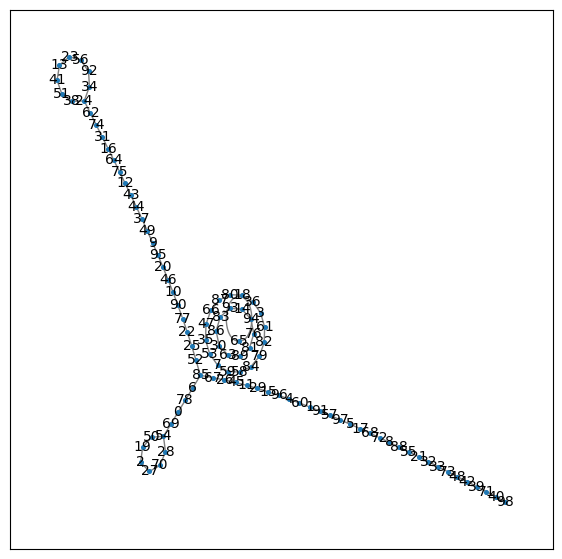

In [ ]:
plt.figure(figsize=(7, 7))
# цвет - это диагноз - надо доработать и сделать там классы ограниченные
colors = ecg_table["Healthy_Status"].tolist()

# задаем матрицу смежности - здесь формируются ребра графа
ecg_graph = nx.from_pandas_edgelist(ecg_table, source = "eeg_date", target = "subject_id")


# subject - это диагноз, надо его привести к чему-то
subjects = list(ecg_table[ecg_table["subject_id"].isin(list(ecg_graph.nodes))]["Healthy_Status"])

#nx.draw_spring(ecg_graph, node_size=17, node_color=subjects)
nx.draw_networkx(ecg_graph,
                 #pos=nx.spring_layout(ecg_graph),
                 #pos=nx.spiral_layout(ecg_graph,scale=1),
                 pos=nx.kamada_kawai_layout(ecg_graph),
                 #pos=nx.planar_layout(ecg_graph),
                 #pos=nx.circular_layout(ecg_graph),
                 #pos=nx.arf_layout(ecg_graph),
                 #pos=nx.spectral_layout(ecg_graph),
                 #pos=nx.multipartite_layout(ecg_graph),
                 #pos=nx.forceatlas2_layout(ecg_graph,scaling_ratio=3),
                 #pos=nx.shell_layout(ecg_graph, scale=1, center=None, dim=2),
                 arrows=True,
                 with_labels=True,
                 node_size=7,
                 font_size = 10,
                 edge_color ='grey',
                 )#, node_color=subjects)

In [ ]:
print(list(ecg_graph.nodes)[0])
list(ecg_graph.neighbors(list(ecg_graph.nodes)[5]))


78


[27, 19]

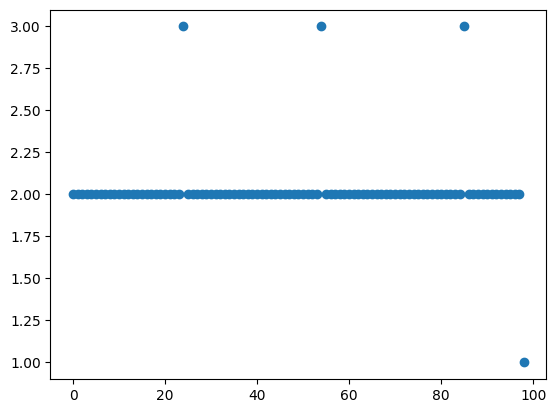

In [ ]:
degrees = [(name, degree) for name, degree in ecg_graph.degree()]
degrees_arr = np.asarray(degrees, dtype=int)
degrees_arr = degrees_arr.T
plt.scatter(degrees_arr[0],degrees_arr[1])

In [ ]:
#nx.clustering(ecg_graph)

#Graph Neural Network with Tensor

In [356]:
#feature_names = set(duplicated_rows.columns) #- {"subject_id", "report"}
feature_names = set(graph_model)# - {"status"}
feature_names

{'edge_key', 'source', 'status', 'target', 'weight'}

In [357]:
edges = graph_model[["source", "target"]].to_numpy().T
print("Edges shape:", edges.shape)

Edges shape: (2, 888)


In [375]:
node_features = tf.cast(graph_model.sort_values("status")[list(feature_names)].to_numpy(), dtype=tf.float32)

#node_features = tf.ones(shape=edges.shape[1]) * graph_model['status']

print("node_features shape:", node_features.shape)
tf.print(node_features)


node_features shape: (888, 5)
[[2661 0 2661 3221 2196]
 [13 0 13 3896 1015]
 [427 0 427 3901 158]
 ...
 [264 1 264 4344 2120]
 [264 1 264 4443 1593]
 [264 1 264 62 426]]


In [376]:
edge_weights = tf.ones(shape=edges.shape[1]) * graph_model['weight']

print("Edges_weights shape:", edge_weights.shape)
tf.print(edge_weights)

Edges_weights shape: (888,)
[264 1282 71 ... 522 2341 2082]


In [377]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
         # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


In [378]:
"""
### Implement a graph convolution layer

We implement a graph convolution module as a [Keras Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer?version=nightly).
Our `GraphConvLayer` performs the following steps:

1. **Prepare**: The input node representations are processed using a FFN to produce a *message*. You can simplify
the processing by only applying linear transformation to the representations.
2. **Aggregate**: The messages of the neighbours of each node are aggregated with
respect to the `edge_weights` using a *permutation invariant* pooling operation, such as *sum*, *mean*, and *max*,
to prepare a single aggregated message for each node. See, for example, [tf.math.unsorted_segment_sum](https://www.tensorflow.org/api_docs/python/tf/math/unsorted_segment_sum)
APIs used to aggregate neighbour messages.
3. **Update**: The `node_repesentations` and `aggregated_messages`—both of shape `[num_nodes, representation_dim]`—
are combined and processed to produce the new state of the node representations (node embeddings).
If `combination_type` is `gru`, the `node_repesentations` and `aggregated_messages` are stacked to create a sequence,
then processed by a GRU layer. Otherwise, the `node_repesentations` and `aggregated_messages` are added
or concatenated, then processed using a FFN.


The technique implemented use ideas from [Graph Convolutional Networks](https://arxiv.org/abs/1609.02907),
[GraphSage](https://arxiv.org/abs/1706.02216), [Graph Isomorphism Network](https://arxiv.org/abs/1810.00826),
[Simple Graph Networks](https://arxiv.org/abs/1902.07153), and
[Gated Graph Sequence Neural Networks](https://arxiv.org/abs/1511.05493).
Two other key techniques that are not covered are [Graph Attention Networks](https://arxiv.org/abs/1710.10903)
and [Message Passing Neural Networks](https://arxiv.org/abs/1704.01212).
"""
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")
        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [379]:
graph_info = (node_features, edges, edge_weights)

In [380]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [381]:
hidden_units = [64, 64]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 10
batch_size = 256
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)
gnn_model.summary()

Model: "gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv1 (GraphConvLayer)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv2 (GraphConvLayer)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ postprocess (Sequential)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ logits (Dense)                       │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [382]:
graph_model.head(3)

,source,target,edge_key,weight,status
2248,62,264,426,264,1
6734,62,1282,647,1282,0
5850,62,71,717,71,1


In [385]:
train_data, test_data = [], []

for _, group_data in graph_model.groupby("source"):
    # Select around 80% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (429, 5)
Test data shape: (459, 5)


In [386]:
#x_train = train_data.drop(columns='status')#.to_numpy()
y_train = train_data["status"]

x_train = train_data.source.to_numpy()

In [387]:
x_test = test_data.source.to_numpy()
#x_test = test_data.drop(columns='status')#.to_numpy()
y_test = test_data["status"]

In [388]:
def run_experiment(model, x_train, y_train, x_test, y_test):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=100, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [389]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(429,)
(429,)
(459,)
(459,)


In [390]:
history = run_experiment(gnn_model, x_train, y_train, x_test, y_test)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node gnn_model_1/graph_conv1_1/GatherV2 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-390-46984e591307>", line 1, in <cell line: 0>

  File "<ipython-input-388-e966cb449d62>", line 13, in run_experiment

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 59, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "<ipython-input-377-8f7199205544>", line 56, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "<ipython-input-378-7a07ccb3f0fa>", line 120, in call

indices[781] = 1394 is not in [0, 888)
	 [[{{node gnn_model_1/graph_conv1_1/GatherV2}}]] [Op:__inference_multi_step_on_iterator_84466]

NameError: name 'history' is not defined

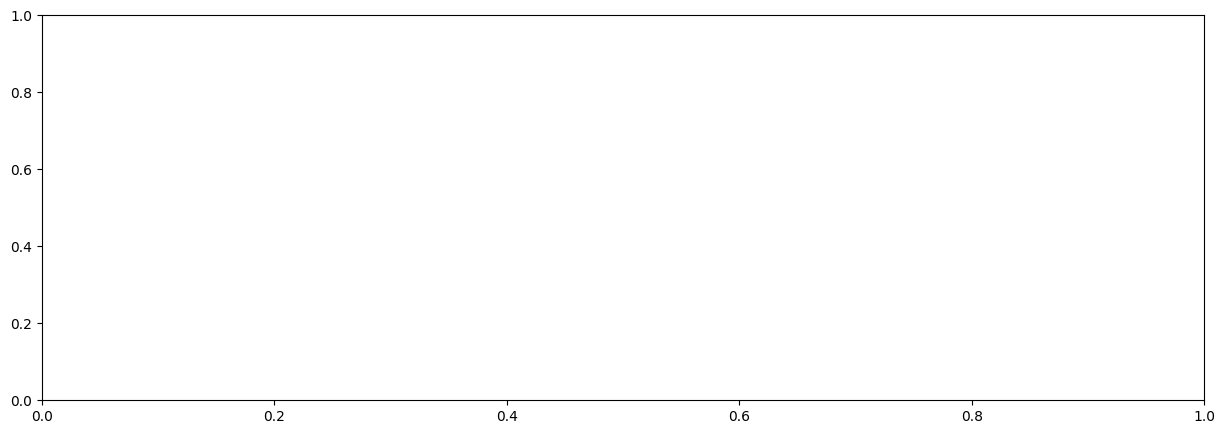

In [123]:
fig, ax1 = plt.subplots(1, figsize=(15, 5))

ax1.plot(history.history["loss"])
ax1.plot(history.history["val_loss"])
ax1.legend(["train", "test"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

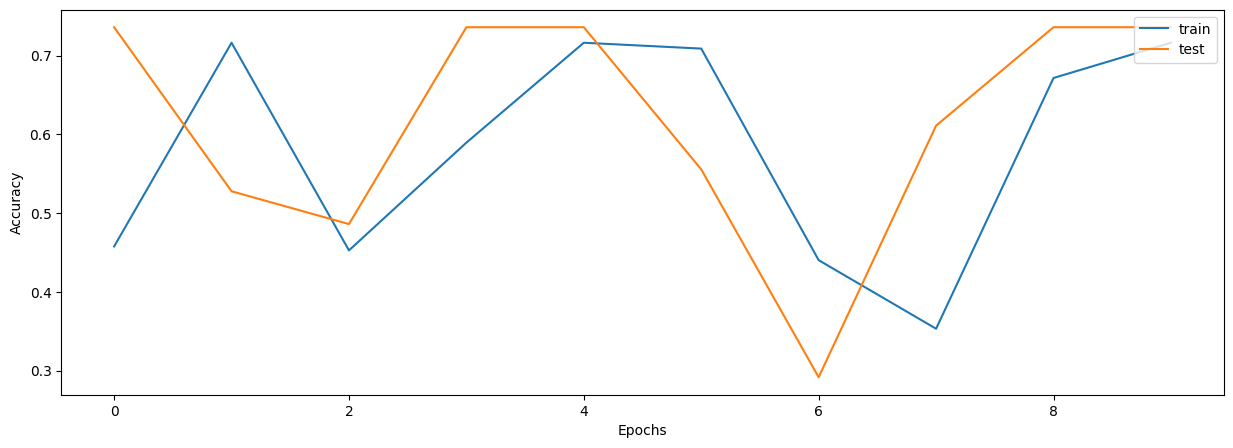

In [ ]:
fig, ax2 = plt.subplots(1, figsize=(15, 5))
ax2.plot(history.history["acc"])
ax2.plot(history.history["val_acc"])
ax2.legend(["train", "test"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()